# MUTCD Sign Detection & Classification
## Notebook for applying the full image detection and classification pipeline
## Imports

In [2]:
%load_ext autoreload
%autoreload 2
import os
import torch
import signutils.detection as detectionutils
import signutils.utils as miscutils
from signutils.data import MakeSquare, ResizeImage, ToTensor, NormalizeImage
from signutils.utils import vec_translate, img_with_bboxes, display_classification, sep_series_on_comma
from signutils.models import load_pretrained_model

from glob import glob

import math
import sys
import time
import torch
import json

import numpy as np
import torch
import torchvision
from train import transforms, coco_utils, coco_eval, utils
from train.coco_eval import CocoEvaluator

from PIL import Image

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms import functional as F
import torchvision.models.detection.mask_rcnn

import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
from glob import glob
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import seaborn as sns

from PIL import Image
from skimage.filters import gaussian
import cv2

import time
import copy

In [4]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
from torch.optim import lr_scheduler
# import torch.functional as F

## Define class to combine RCNN and CNN predictions

In [5]:
class SignDetectClassify():
    '''
    A class that detects and classifies MUTCD signs using two steps 1) a RCNN Detection and 2) a CNN classification
    
    Attributes:
    ------------
    model_detect        -- (Pytorch Model) RCNN model to be used for detection
    model_classify      -- (Pytorch Model) CNN model to be used for classification
    label_encoder       -- (dict) Dictionary that was used to encoder the labels into integers
    detect_thresholds   -- (dict) Dictionary containing thresholds for score, box edge length and aspect ratio
    classify_thresholds -- (dict) Dictionary containing a threshold for score
    (label_decoder)     -- (dict) Uses label_encoder to create a dictionary that decodes integers into labels
    
    Mehtods:
    ---------
    predict                   -- function that accepts a dashcam image path and returns detection and classification predictions
    _detect                   -- hidden function used to perform detction using model_detect
    _classify                 -- hidden function used to perform classification using model_classify
    _threshold_classification -- hidden function used to update all predictions based on classification scores
    '''
    def __init__(
        self, model_detect, model_classify, label_encoder, 
        detect_thresholds={'score': 0.9, 'length': 16, 'AR': 0.1},
        classify_thresholds={'score': 0.3}
    ):
        # defining the models
        self.model_detect = model_detect
        self.model_classify = model_classify
        # Load the models into the GPU
        self.model_detect = self.model_detect.to(device)
        self.model_classify = self.model_classify.to(device)
        # Set the models for inference
        self.model_detect = self.model_detect.eval()
        self.model_classify = self.model_classify.eval()
        
        # define data transformations for the classification task
        norm_mean, norm_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        transform_classify = transforms.Compose([
            MakeSquare(),
            ResizeImage((64, 64)),
            ToTensor(),
            NormalizeImage(norm_mean, norm_std)
        ])
        self.transform_classify = transform_classify
        
        # create label encoder and decoder
        self.label_encoder = label_encoder
        self.label_decoder = {label_encoder[k]: k for k in label_encoder.keys()}
        
        # set threhsolds for detection and classification
        self.detect_thresholds = detect_thresholds
        self.classify_thresholds = classify_thresholds
        
    def _detect(self, in_im_file):
        ''' Function to perform detection predictions using the RCNN
        
        Input: 
        in_im_file -- file path to a dashcam image
        
        Output: 
        all_cropped -- list of PIL images extracted using the predicted bounding boxes
        prediction  -- dictionary containing information for bounding boxes, scores, and labels
        '''
        
        # create instance of ToTensor class
        to_tensor = transforms.ToTensor()
        
        # unpack thresholds
        score_threshold = self.detect_thresholds['score']
        length_threshold = self.detect_thresholds['length']
        AR_min = self.detect_thresholds['AR']
        
        # perform prediction
        # ensure filepath exists
        if os.path.exists(in_im_file):
            # open image
            img_orig = Image.open(in_im_file).convert("RGB")
            # conver to tensor
            img = to_tensor(img_orig)
            # normalize image
            img_norm = F.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], False)

            # The model takes a list of tensors, presumeably to batch predict. Maybe a place to optimize
            imgs_norm = [img_norm.to(device)]
            # Also store the original image for creating the bounding box
            imgs = [img.to(device)]

            # Apply the model to get prediction
            with torch.no_grad():
                prediction = self.model_detect(imgs_norm)
                
            # predictions are returned as a list. we are predicting a single image at a time so we grab the first index
            prediction = prediction[0]
            prediction["sourceId"] = in_im_file # write the image name even if it doesn't pass the thresholds

            # Prediction is a dictionary with fields boxes, labels, and scores
            # Filter the predictions by score threshold 
            boxes_check = [prediction['scores'] > score_threshold][0].cpu().detach().numpy()
            dims_check = detectionutils.check_box_props(prediction['boxes'], [length_threshold, AR_min])
            passed_boxes = np.array(boxes_check)*np.array(dims_check)
            boxes = prediction['boxes'][passed_boxes]
            box_to_cpu = boxes.cpu().detach().numpy()
            
            # store thresholded predictions in the prediction dictionary
            prediction["boxes"] = box_to_cpu
            prediction["scores"] = prediction["scores"][passed_boxes]
            prediction["labels"] = prediction["labels"][passed_boxes]

            # extract detected signs using the predicted bounding boxes
            all_cropped = miscutils.extract_box_indetect(img_orig, box_to_cpu)

            return all_cropped, prediction
                
        else:
            # if no image is found, return empty list of images and empty predictions dictionary
            print(f"Could not locate: {in_im_file}")
            prediction = {'boxes': np.array([]), 'labels': torch.tensor([]), 'scores': torch.tensor([]), "sourceId": in_im_file}
            return ([], prediction)
        
    
    def _classify(self, images):
        ''' Function to perform classification predictions using the CNN
        
        Input: 
        images -- list of PIL images
        
        Output:
        results -- dictionary containing information for predicted labels and scores
        '''
        
        # create empty results dictionary
        results = {
            'labels': [],
            'scores': [],
            'labels_5': [],
            'scores_5': [],
            'labels_idx': [],
        }
        
        # if list of images is empty return empty results
        if len(images)==0:
            return results
        
        # convert images into tensor format expected by pytorch 
        x = images
        x = [self.transform_classify((im, 1))[0] for im in x] # transform all images
        x = [im.unsqueeze(dim=0) for im in x] # add dimension for N number of images
        # combine images into shape (N, C, H, W)
        if len(x) > 1:
            x = torch.concat(x, dim=0)
        else:
            x = x[0]
            
        # move data onto device
        x = x.to(device=device)

        # get classification predictions
        with torch.no_grad():
            pred = self.model_classify(x)

        # apply softmax to make all scores sum to 1
        softmax = nn.Softmax(dim=1)
        pred = softmax(pred)
        
        # move predictions to cpu and format to get top 5 predictions
        pred = pred.detach().to(device='cpu')
        top_pred = torch.argsort(pred, 1, descending=True)
        top_pred = top_pred[:, torch.arange(5)]
        # convert predictions from torch to numpy
        pred = np.array(pred)
        top_pred = np.array(top_pred)
        
        # get scores associated with top predictions
        top_scores = np.array([pred[i, top_pred[i]] for i in range(len(top_pred))])
        
        # store results in dictionary
        results['labels'] = vec_translate(top_pred[:, 0], self.label_decoder) # maps decoder over indicies
        results['scores'] = top_scores[:, 0]
        results['labels_5'] = vec_translate(top_pred, self.label_decoder)
        results['scores_5'] = top_scores
        results['labels_idx'] = top_pred
        
        
        return results
    
    def _threshold_classification(self, result):
        
        if len(result['classification']['scores'])==0:
            return result
        
        mask_class = result['classification']['scores'] >= self.classify_thresholds['score']
        
        if np.any(mask_class == False):
            
            for key in ['boxes', 'labels', 'scores']:
                result['detection'][key] = result['detection'][key][mask_class]
                
            for key in result['classification'].keys():
                result['classification'][key] = result['classification'][key][mask_class]
                
            new_images=[]
            for i, m in enumerate(mask_class):
                if m:
                    new_images.append(result['images'][i])
            result['images'] = new_images
                
        return result
        
        
    def predict(self, image):
        
        images, prediction = self._detect(image)
        classification_results = self._classify(images)
        
        result = {'classification': classification_results, 'detection': prediction, 'images': images}
        
        result = self._threshold_classification(result)
        
        
        return result

## Setting up paths and reading in models
### Set Device for Torch

In [6]:
# Make sure a gpu is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: " + str(device))

Using device: cuda


### Load RCNN model for detection

In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
    # and replace the mask predictor with a new one
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
#                                                        hidden_layer,
#                                                        num_classes)

    return model

In [9]:
src_rel_path = '../'
proj_src_root = os.path.abspath(src_rel_path)
proj_root_path = os.path.abspath(src_rel_path + "../")
data_path = "/home/default/workspace/cs6945share/blyncsy_signs/udot/images"
detect_model_path = os.path.join(proj_src_root, "SignDetection", "DetectionTraining", "models")

detect_model_name = "FasterRCNN_frcnn_sceds3gamma2_run2_signs_Adam_0pt0001_30epochs_bs4_state.pth"
# detect_model_name = "signs_Adam_00005_sched_notrans_entire.pth"
model_file = os.path.join(detect_model_path, detect_model_name)

# # loading in the models
# model_detect = torch.load(model_file)

num_classes=2
model_detect = get_instance_segmentation_model(num_classes)
model_detect.load_state_dict(torch.load(model_file))
# move model to the right device
model_detect = model_detect.to(device)

### Load CNN model for classification

In [10]:
# model_dir = './Synthetic/basic_classification_results/trial-efficientnet_b0-5-adam-001'
# model_dir = './Synthetic/basic_classification_results/trial-EfficientNet-10-Adam-001-0'
model_dir = '../Synthetic/basic_classification_results/trial2-EfficientNet-10-Adam-001-0'

with open(os.path.join(model_dir, 'encoder.json'), 'r') as fl:
    label_encoder = json.load(fl)
label_encoder = json.loads(label_encoder)

model_path = os.path.join(model_dir, 'model_entire.pth')

if os.path.isfile(model_path):
    model_classify = torch.load(model_path)
else:
    out_ftrs = len(label_encoder)
    model_classify = load_pretrained_model('efficientnet_b0', out_ftrs)
    model_classify.load_state_dict(torch.load(os.path.join(model_dir, "model_weights.pth")))

## Perform Predictions
### Create instance of the SignDetectClassify class

In [11]:
# model_detect

In [28]:
sdc = SignDetectClassify(
    model_detect=model_detect, 
    model_classify=model_classify, 
    label_encoder=label_encoder, 
    detect_thresholds={'score': 0.7, 'length': 15, 'AR': 0.1},
    classify_thresholds={'score': 0.45}
)

### Get list of filepaths

In [29]:
all_files = glob('../../blyncsy_signs/udot/images/*.jpg')

### Perform predictions and visualize results

In [54]:
idx = np.random.randint(len(all_files))

# idx = 443

files=[
    '../../blyncsy_signs/udot/images/frame_9e4ffe694d6e84eda9494e906a7ad509.jpg', # no signs
    '../../blyncsy_signs/udot/images/frame_adce02ed18fee1f6f38cf96785d17191.jpg', # filter sign
    '../../blyncsy_signs/udot/images/frame_cfb21a80da297a48795d96ee65fa56ab.jpg', # warning stop light
    '../../blyncsy_signs/udot/images/frame_d356c1fea45610978e6d26effdcb6065.jpg', # warning turn
    '../../blyncsy_signs/udot/images/frame_9dcbc8819926a8a8a5b7f8df3ea99dbe.jpg', # speed limit
    '../../blyncsy_signs/udot/images/frame_55aba2bdf4b72b7dfc5ceb13805c0755.jpg', # electric
    '../../blyncsy_signs/udot/images/frame_02cdf284aa5fe2ab103e9ef72c137593.jpg', # electric
    '../../blyncsy_signs/udot/images/frame_dbe164462f2111a694a2028a068f2c9d.jpg', # regulatory turn
    '../../blyncsy_signs/udot/images/frame_be6cbc350762ff66e590f30d095e8c57.jpg', # interstate
    '../../blyncsy_signs/udot/images/frame_e7bc7cd5a42fcfa895428651e1d6f765.jpg',
    '../../blyncsy_signs/udot/images/frame_77952d465c6eca2692776764188e5493.jpg',
    '../../blyncsy_signs/udot/images/frame_bd37407b56778e452fae3136c37dfe65.jpg',
    '../../blyncsy_signs/udot/images/fod_20210825_183600_8549361d-7d0c-4950-b851-b606096e7256.jpg',
    '../../blyncsy_signs/udot/images/frame_6ccfd63e2aed531eecde3c9a7ef9c310.jpg'
]

output_dir = 'product_results'

for count, fl in enumerate(files):
    
    out_path = os.path.join(output_dir, f"{count:03}")
    os.makedirs(out_path, exist_ok=True)


    r = sdc.predict(fl)

    img_with_bboxes(r, saveim=True, showim=False, out_path=out_path)
    if len(r['classification']['labels'])>0:
        display_classification(r, showim=False, saveclass=True, out_path=os.path.join(out_path, 'classification'))
        plt.close()
#     break

In [52]:
f"./product_results/{count:03}_classify.png"

'./product_results/001_classify.png'

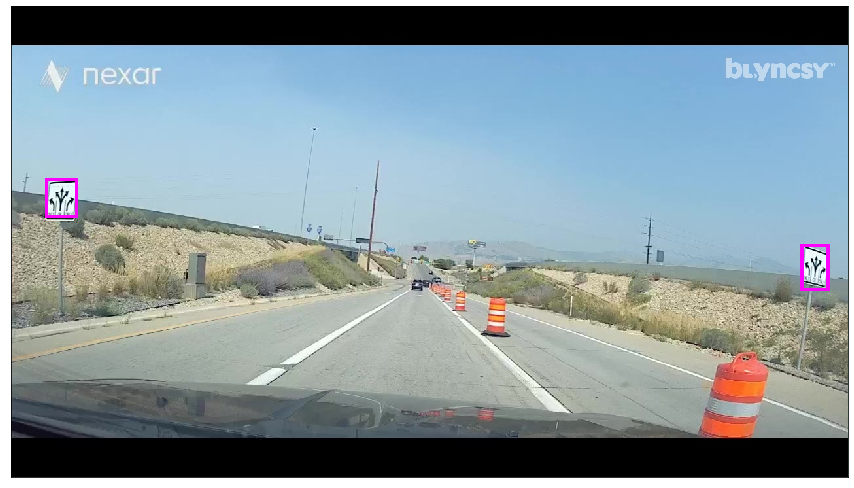

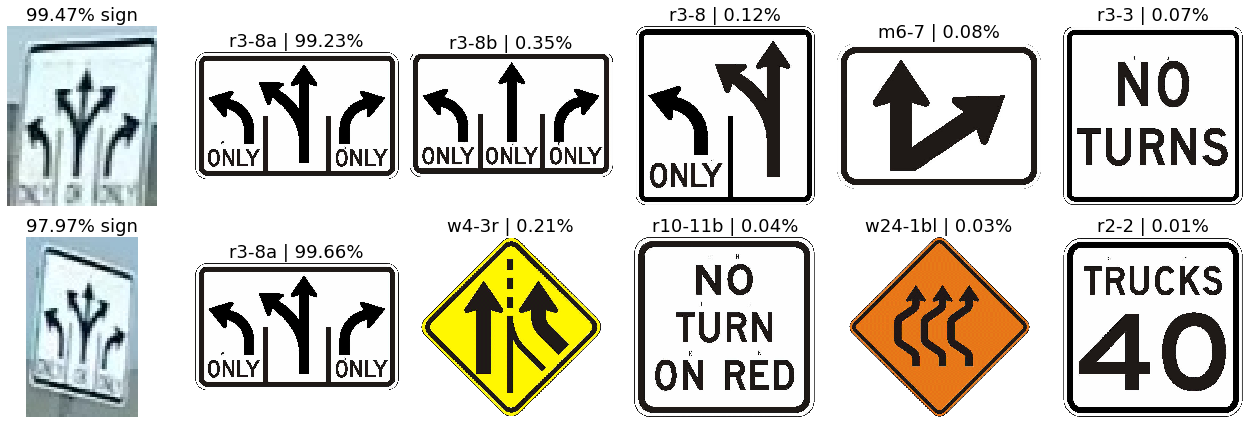

In [40]:
idx = np.random.randint(len(all_files))

# idx = 443

fl = all_files[idx]
# fl = '../../blyncsy_signs/udot/images/frame_9e4ffe694d6e84eda9494e906a7ad509.jpg' # no signs
# fl = '../../blyncsy_signs/udot/images/frame_adce02ed18fee1f6f38cf96785d17191.jpg' # filter sign
# fl = '../../blyncsy_signs/udot/images/frame_cfb21a80da297a48795d96ee65fa56ab.jpg' # warning stop light
# fl = '../../blyncsy_signs/udot/images/frame_d356c1fea45610978e6d26effdcb6065.jpg' # warning turn
# fl = '../../blyncsy_signs/udot/images/frame_9dcbc8819926a8a8a5b7f8df3ea99dbe.jpg' # speed limit
# fl = '../../blyncsy_signs/udot/images/frame_55aba2bdf4b72b7dfc5ceb13805c0755.jpg' # electric
# fl = '../../blyncsy_signs/udot/images/frame_02cdf284aa5fe2ab103e9ef72c137593.jpg' # electric
# fl = '../../blyncsy_signs/udot/images/frame_dbe164462f2111a694a2028a068f2c9d.jpg' # regulatory turn
# fl = '../../blyncsy_signs/udot/images/frame_be6cbc350762ff66e590f30d095e8c57.jpg' # interstate
# fl = '../../blyncsy_signs/udot/images/frame_e7bc7cd5a42fcfa895428651e1d6f765.jpg'
# fl = '../../blyncsy_signs/udot/images/frame_77952d465c6eca2692776764188e5493.jpg'
# fl = '../../blyncsy_signs/udot/images/frame_bd37407b56778e452fae3136c37dfe65.jpg'
# fl = '../../blyncsy_signs/udot/images/fod_20210825_183600_8549361d-7d0c-4950-b851-b606096e7256.jpg'
# fl = '../../blyncsy_signs/udot/images/frame_6ccfd63e2aed531eecde3c9a7ef9c310.jpg'


files


for count, fl in enumerate()


r = sdc.predict(fl)



f"./product_results/{count:03}_detect.png"
f"./product_results/{count:03}_classify.png"

display_classification(r, showim=True, saveclass=False, out_path='TESTIMAGE.png')
plt.show()

In [47]:
f"{200:04}"

'0200'

## Setting up the geojson file

In [14]:
# sample = True
sample = False

# Define the input map file
# in_map_file = os.path.join("/home/default/workspace/cs6945share/blyncsy_signs/udot", "udot_signs_pilot.geojson")
in_map_file = os.path.join("/home/default/workspace/cs6945share/sign_project/product", "udot_signs_all.geojson")
# Define the product map file
out_map_file = os.path.join(proj_src_root, "product", "udot_sl_county_signs_2021_11_14_done.geojson")

# Load the map file into a GeoPandas object
in_map_df = gpd.read_file(in_map_file)
in_map_df = in_map_df.rename(columns={"sourceIds":"sourceId"}) # renaming prevents weird things in the applying network step

if sample:
#     sample_file = os.path.join(proj_root_path, "product", "udot_sl_county_signs_2021_11_14_100samples_done.geojson")
    in_map_df.sample(n=20).to_file(in_map_file)
    in_map_df = in_map_df.rename(columns={"sourceIds":"sourceId"}) # renaming prevents weird things in the applying network step
    # Example of reducing the dataset for testing the code below:
    in_map_df = in_map_df.sample(n=20)

    out_map_file = os.path.join(proj_src_root, "product", "udot_sl_county_signs_2021_11_14_100samples_done.geojson")

# Take a look at the data
print(len(in_map_df))
in_map_df.head()

6887


,id,OBJECTID,LAYER_ID,MANDLI_ID,ELEMENT_ID,ROUTE,ROUTE_DIR_,TRAVEL_DIR,START_ACCU,END_ACCUM,...,COLL_DATE,GHOSTED,ERR_CD,pos_str,near_str,sourceId,geometry_y,render_type,proxy_host,geometry
0,udot_signs_pilot.fid-5c4a87e6_1803d92a393_-2d22,3,93,31796671,410,0015P,1333,+,296.272,296.272,...,2017-08-14,true,0,"-111.90288081206985,40.59682688256679","-111.90288081206985,40.59682688256679",images/frame_eb21a41156a522298b7ba23ae61ca36b....,POINT (-111.9028808120699 40.59682688256679),multiple_images,http://image-proxy-segs.webmaps.svc.cluster.local,MULTIPOINT (-111.90288 40.59683)
1,udot_signs_pilot.fid-5c4a87e6_1803d92a393_-2d21,4,93,31796684,410,0015P,1333,+,296.271,296.271,...,2017-08-14,true,0,"-111.90287677593928,40.59682556270834","-111.90287677593928,40.59682556270834",images/frame_0b9bccb20244ef7f55acadf2f6f38241....,POINT (-111.9028767759393 40.59682556270834),multiple_images,http://image-proxy-segs.webmaps.svc.cluster.local,MULTIPOINT (-111.90288 40.59683)
2,udot_signs_pilot.fid-5c4a87e6_1803d92a393_-2d20,10,93,31812380,410,0015P,1333,+,299.451,299.451,...,2017-08-14,true,0,"-111.902991328206,40.64217310205464","-111.902991328206,40.64217310205464",images/frame_18034a8a9d545db3bbe495d915702635....,POINT (-111.902991328206 40.64217310205464),multiple_images,http://image-proxy-segs.webmaps.svc.cluster.local,MULTIPOINT (-111.90299 40.64217)
3,udot_signs_pilot.fid-5c4a87e6_1803d92a393_-2d1f,24,93,31810309,410,0015P,1333,+,298.998,298.998,...,2017-08-14,true,0,"-111.90457595546886,40.635760696859116","-111.90457595546886,40.635760696859116",images/frame_b47672bd5866abc7fce7ba2cfbe8a5ac....,POINT (-111.9045759554689 40.63576069685912),multiple_images,http://image-proxy-segs.webmaps.svc.cluster.local,MULTIPOINT (-111.90458 40.63576)
4,udot_signs_pilot.fid-5c4a87e6_1803d92a393_-2d1e,26,93,31823368,410,0015P,1333,+,300.757,300.757,...,2017-08-14,true,0,"-111.90091452028716,40.66118759015589","-111.90091452028716,40.66118759015589",images/frame_96f48fb39ae8bad73ea55c16bd21b033....,POINT (-111.9009145202872 40.66118759015589),multiple_images,http://image-proxy-segs.webmaps.svc.cluster.local,MULTIPOINT (-111.90091 40.66119)


In [15]:
# all_files = glob(os.path.join(data_path, "*"))
sourceIds = in_map_df.sourceId
all_files = sep_series_on_comma(sourceIds)

In [16]:
def create_im_tag(row, folder_path="/home/default/workspace/cs6945share/sign_project/product/scratch", ws_prefix = None):
    """Function for creating an html image tag

    This function was designed to be used with a Pandas apply method.

    Parameters
    ----------
    row : dict
        a dict containing the field "sourceId" which is the filename of an image.
    folder_path : str
        a string representing the path to the folder (in the workspace) where 
        images are located. Must end in a forward slash
    ws_prefix : str, optional
        a string representing the workspace prefix (usually the owner's last name).
        Must **not** have a trailing foward slash, e.g. /henderson. If this arg
        is not provided then the function will try to determine it from the 
        environment.
        
    Returns
    -------
    str
        a string representing an HTML element that can show an image
    """
    
    if ws_prefix is None:
        ws_prefix = os.environ["WS_PROXY"]
    # hardcoded to get just the 1st image in the list
#     s = os.path.join(ws_prefix, "mini_browser", "home", "default", "workspace", folder_path, row["sourceId"].split(",")[0].split("/")[1])
    s = ws_prefix + "/mini-browser" + "/home/default/workspace" + folder_path + "/" + row["sourceId"].split(",")[0].split("/")[1] 
    html = """ \
        <div style='width:300; height:200'> \
            <a href='{0}' target='_blank' rel='noopener noreferrer'> \
                <img width=100% src='{0}'/> \
            </a> \
        </div>
    """.format(s)
    return html

def update_geojson(df, i, out_path, detections, labels):
    im_data = in_map_df.iloc[i,:].to_dict()
    im_data["img"] = create_im_tag(im_data, folder_path=out_path)
    im_data["detected classes"] = labels
    detections.append(im_data)
    return detections

def update_geojson2(df, i, out_path, detections, col='classImages'):
    im_data = in_map_df.iloc[i,:].to_dict()
    im_data[col] = create_im_tag(im_data, folder_path=out_path)
    d = detections[-1]
    im_name = im_data[col]
    im_name = im_name.replace('.jpg', '.png')
    d[col] = im_name
    detections[-1] = d
    return detections

# Define a function that can be used to generate image tags


def write_signs_gdf(data_dict, file_path):
    # Create the output GeoDataFrame and write to file
    print(f"Writing progress to file: {file_path}")
    detect_df = gpd.GeoDataFrame(data_dict, geometry="geometry", crs="EPSG:4326")
    detect_df.to_file(file_path)

# Applying the model to images

In [ ]:
sample=False

# sdc = SignDetectClassify(
#     model_detect=model_detect, 
#     model_classify=model_classify, 
#     label_encoder=label_encoder, 
#     detect_thresholds={'score': 0.7, 'length': 15, 'AR': 0.1},
#     classify_thresholds={'score': 0.45}
# )

sdc = SignDetectClassify(
    model_detect=model_detect, 
    model_classify=model_classify, 
    label_encoder=label_encoder, 
    detect_thresholds={'score': 0.66, 'length': 15, 'AR': 0.1},
    classify_thresholds={'score': 0.45}
)


if sample:
    out_path = os.path.join(proj_src_root, "product", "bboxes_100samples")
    out_path_class = os.path.join(proj_src_root, "product", "classes_100samples")
else:
    out_path = os.path.join(proj_src_root, "product", "bboxes")
    out_path_class = os.path.join(proj_src_root, "product", "classes")
    
os.makedirs(out_path, exist_ok=True)
os.makedirs(out_path_class, exist_ok=True)

detections = []

# in_im_file = all_files[120]
# idxs = [np.random.randint(len(all_files))]
idxs = range(len(all_files))

# idx = 2 # to replicate the bug
for ind in tqdm(idxs):
# for ind in idxs:
#     print(ind)
    in_im_file = all_files[ind]

    r = sdc.predict(in_im_file)
    
    if len(r['classification']['labels']) == 0:
        labels = " "
    else:   
        labels = ', '.join(list(r["classification"]["labels"]))
    
        detections = update_geojson(in_map_df, ind, out_path, detections, labels)
        detections = update_geojson2(in_map_df, ind, out_path_class, detections)
        img_with_bboxes(r, saveim=True, showim=False, out_path=out_path)
        display_classification(r, showim=False, saveclass=True, out_path=os.path.join(out_path_class, os.path.basename(in_im_file))[:-4])
        plt.close()
        
#     if ind % 100 == 0:
#         print(f"{ind}/{len(all_files)}")
#         write_signs_gdf(detections, out_map_file)
    
write_signs_gdf(detections, out_map_file)

  0%|          | 0/6887 [00:00<?, ?it/s]

Could not locate: /cs6945share/blyncsy_signs/udot/images/frame_70ce8fc70c0a95c4ab735d47b8e81624.jpg


In [ ]:
print('done')